In [38]:
from transformers import pipeline
from datasets import load_dataset, DatasetDict, Dataset

from transformers import (
    AutoTokenizer,
    AutoConfig, 
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer)

import evaluate
from evaluate import evaluator
import pandas as pd

In [39]:
df = pd.read_csv('../data/task_2_model_reuse.csv')

df = df[df["Citation Sentence"].notna()]
df = df.dropna(subset=['How does it use <model.name> ?'])
df.head(3)

,model.name,model.title,citation.openAccessPdf,How does it use <model.name> ?,Secondary use of the <model.name> (if applicable),Citation Sentence,Does the paper introduce a new model?,"If yes, what is the name of the model? (not named is fine)",Does the paper use AI model?,"If yes, which model it is using?",Notes
1,MobileNet,MobileNets: Efficient Convolutional Neural Net...,https://www.frontiersin.org/articles/10.3389/f...,Uses,NaN,Depthwise separable convolutions boosted compu...,No,NaN,Yes,NaN,Good example how models detect plant disease i...
3,Robot Parkour,Robot Parkour Learning,https://arxiv.org/pdf/2310.04828,Background,NaN,Recent advancements in reinforcement learning ...,Yes,NaN,Yes,NaN,NaN
4,ReLU (NORB),Rectified Linear Units Improve Restricted Bolt...,https://arxiv.org/pdf/2308.16316,Background,NaN,"However, DM-GAN’s computational complexity and...",Yes,NaN,Yes,NaN,NaN


In [60]:
# surround numerical citations with <cite> tags
df['Citation Sentence'] = df['Citation Sentence'].replace(r'\[(\d+)\]', r'<cite>[\1]</cite>', regex=True)

# surround surname year citations with <cite> tags
df['Citation Sentence'] = df['Citation Sentence'].replace(r'(\w+ et al\. \(\d+\))', r'<cite>\1</cite>', regex=True)

df["Citation Sentence"].head(2)

1    Depthwise separable convolutions boosted compu...
3    Recent advancements in reinforcement learning ...
Name: Citation Sentence, dtype: object

In [61]:
print(df["Citation Sentence"].iloc[0])

Depthwise separable convolutions boosted computational efficiency in MobileNetV1 <cite>Howard et al. (2017)</cite>. MobileNetV2 added a resource-efficient block with inverted residuals and linear bottlenecks to improve efficiency <cite>Howard et al. (2018)</cite>.


# Helper Functions

In [62]:
def get_classifier(model_checkpoint):
    tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
    model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint)
    classifier = pipeline('text-classification', model=model, tokenizer=tokenizer)
    return classifier

# Model: MultiCite

In [63]:
multicite = get_classifier('allenai/multicite-multilabel-scibert')

In [64]:
predictions = multicite(df["Citation Sentence"].tolist())

In [65]:
predictions[:5]

[{'label': 'background', 'score': 0.9876697659492493},
 {'label': 'background', 'score': 0.9977023005485535},
 {'label': 'background', 'score': 0.6258440017700195},
 {'label': 'background', 'score': 0.9973133206367493},
 {'label': 'background', 'score': 0.9976673722267151}]

In [66]:
predictions=[result['label'] for result in predictions]

In [67]:
set(predictions)

{'background',
 'differences',
 'future_work',
 'motivation',
 'similarities',
 'uses'}

In [68]:
df["y"] = df["How does it use <model.name> ?"].str.lower().str.replace(" ", "_")

df["y"].unique()

array(['uses', 'background', 'extends', 'motivation', 'differences',
       'similarities', 'future_work'], dtype=object)

In [69]:
accuracy = evaluate.load('accuracy')

references=df["y"].tolist()

# Assuming 'labels_dict' maps unique string labels to integers
labels_dict = {'background': 0, 'uses': 1, 'motivation': 2,
               'extends': 3, 'differences': 4, 'similarities':4,
               'compareorcontrast': 4, 'future_work': 5, 'future': 5,}  

# Convert 'references' and 'predictions' to integer labels
references_int = [labels_dict[label] for label in references]
predictions_int = [labels_dict[pred] for pred in predictions]

acc = accuracy.compute(
    references=references_int, 
    predictions=predictions_int)
print(acc)

{'accuracy': 0.6228070175438597}


In [70]:
def agg_classes(predictions):
    predictions = ['compareorcontrast' if pred == 'similarities' else pred for pred in predictions]
    predictions = ['compareorcontrast' if pred == 'differences' else pred for pred in predictions]
    return predictions

predictions = agg_classes(predictions)
df["y"] = agg_classes(df["y"].tolist())

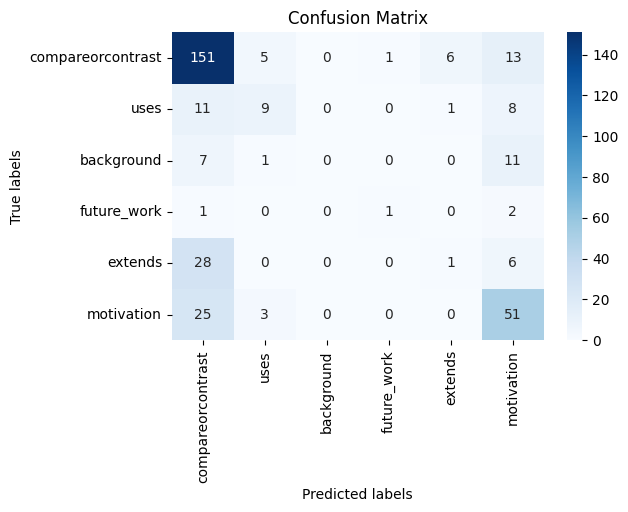

In [71]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Generating the confusion matrix
cm = confusion_matrix(df["y"], predictions)

# Visualizing the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=set(df["y"]), yticklabels=set(df["y"]))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


# Load ACL-ARC dataset

In [52]:
dataset = load_dataset('yxchar/citation_intent-tlm', split="train")

In [53]:
predictions = multicite(dataset['text'])

In [54]:
predictions=[result['label'] for result in predictions]
set(predictions)

{'background',
 'differences',
 'extends',
 'future_work',
 'motivation',
 'similarities',
 'uses'}

In [55]:
predictions = [prediction.replace('similarities', 'compare') for prediction in predictions]
predictions = [prediction.replace('differences', 'compare') for prediction in predictions]

In [56]:
# Iterate over the dataset and replace labels
id2label = {
    0: "background", 1: "uses", 2: "compare", 3: "extends", 5: "future_work", 4: "motivation"}
y = []
for example in dataset:
    y_label = id2label[example['label']]
    y.append(y_label)

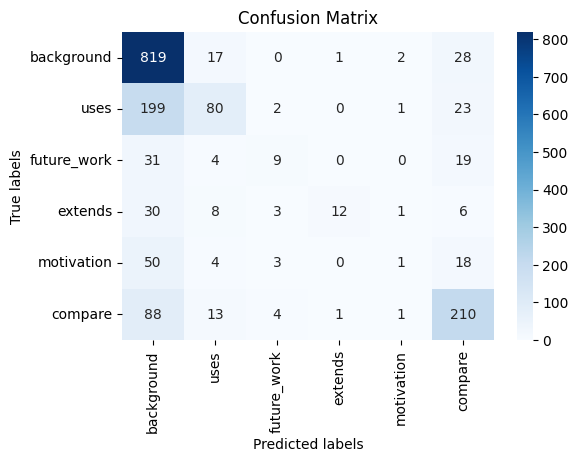

In [57]:
# Generating the confusion matrix
cm = confusion_matrix(y, predictions)

# Visualizing the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=set(y), yticklabels=set(y))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()